In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from candy import Candy
from analysis import *
from torch.utils.data import random_split


In [43]:
raw = get_df_from_board_files()

In [52]:
# Create a list of dictionaries with the boards and scores
data = [{'board': state_to_board(state, 7, 7).board, 'score': score} for state, score in zip(raw["state"], raw["Move_1_Q"])]

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data, columns=['board', 'score'])

In [78]:

# Example unique IDs and types
unique_ids = [1, 2, 3, 4, 5, 6, 7]
unique_types = ["normal", "sachet", "raye_hor", "raye_ver", "disco"]

# Mapping for one-hot encoding
id_to_index = {id_: idx for idx, id_ in enumerate(unique_ids)}
type_to_index = {type_: idx for idx, type_ in enumerate(unique_types)}

# One-hot encode a single Candy object
def one_hot_encode_candy(candy):
    id_one_hot = np.zeros(len(unique_ids))
    type_one_hot = np.zeros(len(unique_types))
    id_one_hot[id_to_index[candy.id]] = 1
    type_one_hot[type_to_index.get(candy.type, 0)] = 1  # Default to first index if type missing
    return np.concatenate([id_one_hot, type_one_hot])

# Convert a 7x7 grid of Candy objects to a numerical 3D array
def preprocess_board(board):
    grid_size = (7, 7)
    encoded_board = np.zeros((*grid_size, len(unique_ids) + len(unique_types)))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            encoded_board[i, j, :] = one_hot_encode_candy(board[i][j])
    return encoded_board

# Custom PyTorch Dataset
class CandyDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        board = self.dataframe.iloc[idx, 0]  # Board state
        score = self.dataframe.iloc[idx, 1]  # Score
        processed_board = preprocess_board(board)
        return torch.tensor(processed_board, dtype=torch.float32), torch.tensor(score, dtype=torch.float32)


# CNN Model
class CandyCNN(nn.Module):
    def __init__(self):
        super(CandyCNN, self).__init__()
        in_channels = len(unique_ids) + len(unique_types)  # Total channels from encoding
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size after convolutions and pooling
        self._calculate_fc_input_size()

        self.fc1 = nn.Linear(self.fc_input_size, 128)  # Adjusted input size
        self.fc2 = nn.Linear(128, 1)

    def _calculate_fc_input_size(self):
        # Dummy input to calculate output size after convolutions and pooling
        dummy_input = torch.zeros(1, len(unique_ids) + len(unique_types), 7, 7)
        x = self.pool(torch.relu(self.conv1(dummy_input)))
        x = self.pool(torch.relu(self.conv2(x)))
        self.fc_input_size = np.prod(x.size()[1:])  # Flattened size after pooling

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten for FC layer
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Training Function
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs.permute(0, 3, 1, 2))  # Adjust dimensions to (N, C, H, W)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(dataloader):.4f}")

In [87]:
len(dataset)

2408

In [90]:
len(train_dataset)

1926

In [79]:

# Create dataset
dataset = CandyDataset(df)

# Calculate the size of the training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split dataset into train and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model, loss, and optimizer
model = CandyCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_dataloader, criterion, optimizer, epochs=200)

Epoch 1/200, Loss: 379506.5876
Epoch 2/200, Loss: 110739.3035
Epoch 3/200, Loss: 78944.3493
Epoch 4/200, Loss: 78563.4845
Epoch 5/200, Loss: 79048.0736
Epoch 6/200, Loss: 78711.1655
Epoch 7/200, Loss: 79408.7180
Epoch 8/200, Loss: 78801.2320
Epoch 9/200, Loss: 78247.8512
Epoch 10/200, Loss: 78551.0511
Epoch 11/200, Loss: 81492.4775
Epoch 12/200, Loss: 78182.3999
Epoch 13/200, Loss: 78364.0395
Epoch 14/200, Loss: 78134.8998
Epoch 15/200, Loss: 78096.9884
Epoch 16/200, Loss: 78077.9765
Epoch 17/200, Loss: 77832.0916
Epoch 18/200, Loss: 77564.1740
Epoch 19/200, Loss: 77242.3971
Epoch 20/200, Loss: 77894.2942
Epoch 21/200, Loss: 78025.1435
Epoch 22/200, Loss: 77837.2177
Epoch 23/200, Loss: 76955.0099
Epoch 24/200, Loss: 77110.0269
Epoch 25/200, Loss: 77041.5447
Epoch 26/200, Loss: 76789.0771
Epoch 27/200, Loss: 76369.4760
Epoch 28/200, Loss: 76477.9406
Epoch 29/200, Loss: 76904.0666
Epoch 30/200, Loss: 76240.9463
Epoch 31/200, Loss: 75791.6751
Epoch 32/200, Loss: 75484.1246
Epoch 33/200, L

In [80]:
print(model(torch.tensor(preprocess_board(state_to_board(raw["state"][0], 7, 7).board), dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2))) # Example prediction
# real value
print(raw["Move_1_Q"][0])

tensor([[914.4167]], grad_fn=<AddmmBackward0>)
818.8674953682844


In [103]:
from matplotlib import pyplot as plt

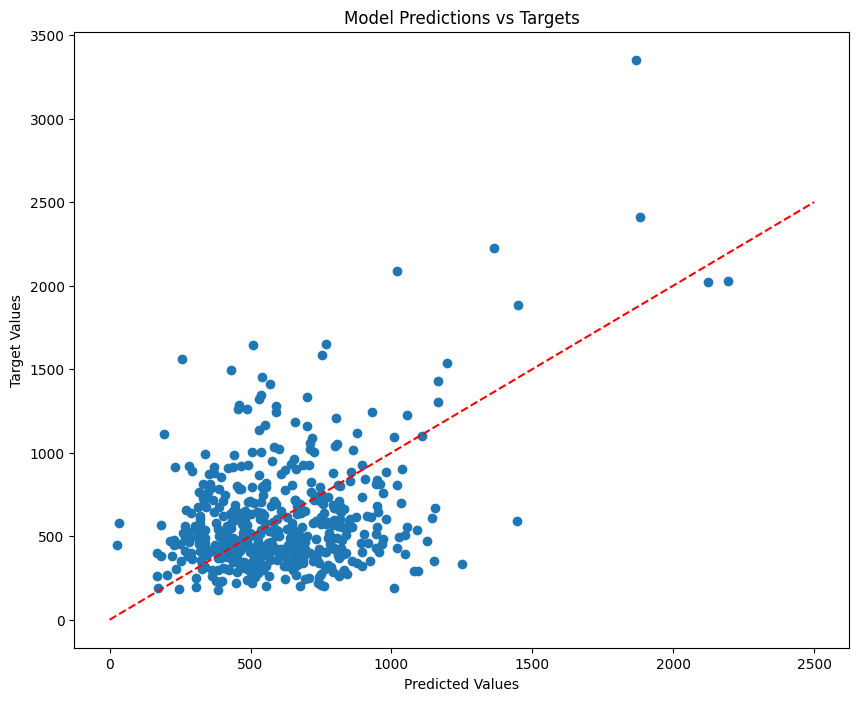

In [118]:
import matplotlib.pyplot as plt

# Show the prediction on the validation set
model.eval()
with torch.no_grad():
    inp = []
    tar = []
    for inputs, targets in val_dataloader:
        outputs = model(inputs.permute(0, 3, 1, 2))
        inp.extend(outputs.squeeze().numpy().flatten())
        tar.extend(targets.squeeze().numpy().flatten())

    plt.figure(figsize=(10, 8))
    plt.scatter(inp, tar)
    plt.plot([0, 2500], [0, 2500], color='red', linestyle='--')
    plt.title("Model Predictions vs Targets")
    plt.xlabel("Predicted Values")
    plt.ylabel("Target Values")
    plt.show()

In [84]:
len(train_dataloader)

61

In [83]:
len(val_dataloader)

16

In [ ]:
# Plo

In [39]:
import numpy as np

# Assume we know all unique IDs and types
unique_ids = [1, 2, 3, 4, 5, 6]
unique_types = ["normal", "striped", "wrapped", "disco"]
id_to_index = {id_: idx for idx, id_ in enumerate(unique_ids)}
type_to_index = {type_: idx for idx, type_ in enumerate(unique_types)}

# One-hot encode a single Candy object
def one_hot_encode_candy(candy):
    id_one_hot = np.zeros(len(unique_ids))
    type_one_hot = np.zeros(len(unique_types))
    id_one_hot[id_to_index[candy.id]] = 1
    type_one_hot[type_to_index.get(candy.type, 0)] = 1  # Default to first index if type missing
    return np.concatenate([id_one_hot, type_one_hot])

# Convert a 7x7 grid of Candy objects to a numerical 3D array
def preprocess_board(board):
    grid_size = (7, 7)
    encoded_board = np.zeros((*grid_size, len(unique_ids) + len(unique_types)))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            encoded_board[i, j, :] = one_hot_encode_candy(board[i][j])
    return encoded_board

In [40]:
processed_board = preprocess_board(b)
print("Processed Board Shape:", processed_board.shape)  # (7, 7, N + M)


Processed Board Shape: (7, 7, 10)
